In [1]:
# import os
# import sys
# sys.path.append('/home/qy707/CP4GenerativeModel')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import multivariate_normal

from pathlib import Path

In [2]:
fontsize=36

In [3]:

data_path = Path('../../Data/')

In [25]:
def load_CP4Gen_computes(output_saving_path, k):

    scores = np.load(output_saving_path / f'CP4Gen_scores_{k}.npy')
    volumes = np.load(output_saving_path / f'CP4Gen_volumes_{k}.npy')
    ks = np.load(output_saving_path / f'CP4Gen_ks_{k}.npy')
    quant_score = np.load(output_saving_path / f'CP4Gen_quant_score_{k}.npy')

    return scores, volumes, ks, quant_score

In [26]:
def load_PCP_computes(output_saving_path):

    scores = np.load(output_saving_path / f'PCP_scores.npy')
    volumes = np.load(output_saving_path / f'PCP_volumes.npy')
    ks = np.load(output_saving_path / f'PCP_ks.npy')
    quant_score = np.load(output_saving_path / f'PCP_quant_score.npy')

    return scores, volumes, ks, quant_score

In [27]:
def get_density_2d(y_ens, means, covariances, weights, quant_score, grid_res=100):
    # y_ens: (N_ens, 2)

    k = len(means)

    buffle0 = (np.max(y_ens[:, 0]) - np.min(y_ens[:, 0])) * 0.4
    buffle1 = (np.max(y_ens[:, 1]) - np.min(y_ens[:, 1])) * 0.4
    X_grid = np.linspace(np.min(y_ens[:, 0]) - buffle0, np.max(y_ens[:, 0]) + buffle0, grid_res)
    Y_grid = np.linspace(np.min(y_ens[:, 1]) - buffle1, np.max(y_ens[:, 1]) + buffle1, grid_res)
    x, y = np.meshgrid(X_grid, Y_grid)
    pos = np.dstack((x, y))
    dens = np.zeros((k, x.shape[0], x.shape[1]), float)

    for i in range(k):
        dens[i] = - (multivariate_normal.logpdf(pos, mean=means[i], cov=covariances[i], allow_singular=True) + np.log(weights[i]))
    dens = np.min(dens, axis=0)
    
    dens_new = np.zeros(dens.shape) * np.nan
    dens_new[dens <= quant_score] = 1
    dens_new[dens > quant_score] = 0
    volume = np.sum(dens_new) * (X_grid[1] - X_grid[0]) * (Y_grid[1] - Y_grid[0])

    return x, y, dens_new, volume

In [28]:
def corr_picking(Y_ens):
    # Y_ens: (n_batch, n_ens, 2)
    
    corrs = []
    for i in range(len(Y_ens)):
        y_ens = Y_ens[i].T
        corr = np.corrcoef(y_ens)[0, 1]
        corrs.append(corr)

    corrs = np.array(corrs)
    idxs = np.argsort(np.abs(corrs))

    return idxs

# Mengze-2

In [29]:
class Data:
    def __init__(self, dataset_name, k_optimal, idx=None):
        self.dataset_name = dataset_name
        self.k_optimal = k_optimal

        self.Y_ens_test = np.load(data_path / f'Y_ens_test_{dataset_name}.npy')
        self.Y_test = np.load(data_path / f'Y_test_{dataset_name}.npy')

        #idx = np.argsort(PCP_volumes - CP_volumes)[-2]
        if idx is None:
            self.idx = corr_picking(self.Y_ens_test)[1]
        else:
            self.idx = idx

        self.CP_x = np.load(data_path / f'CP_x_{dataset_name}.npy')
        self.CP_y = np.load(data_path / f'CP_y_{dataset_name}.npy')
        self.CP_dens = np.load(data_path / f'CP_dens_{dataset_name}.npy')
        self.CP_volume = np.load(data_path / f'CP_volume_{dataset_name}.npy')

        self.PCP_x = np.load(data_path / f'PCP_x_{dataset_name}.npy')
        self.PCP_y = np.load(data_path / f'PCP_y_{dataset_name}.npy')
        self.PCP_dens = np.load(data_path / f'PCP_dens_{dataset_name}.npy')
        self.PCP_volume = np.load(data_path / f'PCP_volume_{dataset_name}.npy')


In [30]:
data_m = Data('Mengze_2', 1)

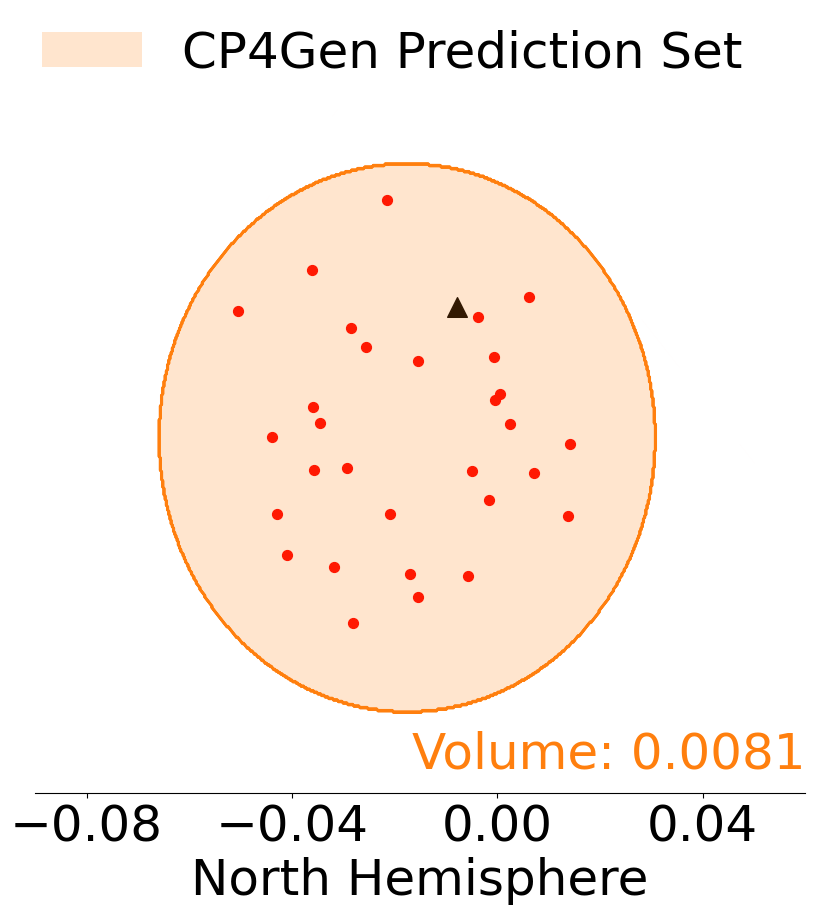

In [55]:
c_name = 'tab:orange'
dens = data_m.CP_dens
vol = data_m.CP_volume
cp_name = 'CP4Gen'

fig, ax = plt.subplots(1, figsize=(10, 10))

ax.scatter(data_m.Y_ens_test[data_m.idx, :, 0], data_m.Y_ens_test[data_m.idx, :, 1], marker='o', color = 'red', s=50)
ax.scatter(data_m.Y_test[data_m.idx, 0], data_m.Y_test[data_m.idx, 1], marker='^', color = 'black', s=200)
ax.contour(data_m.CP_x, data_m.CP_y, dens, colors=c_name)
ax.contourf(data_m.CP_x, data_m.CP_y, dens, levels=[0.5, 1.5], colors=c_name, alpha=0.2)

contour_patch = Patch(facecolor=c_name, alpha=0.2, label=f'{cp_name} Prediction Set')
ax.legend(handles=[contour_patch], loc='upper left', fontsize=fontsize, frameon=False, bbox_to_anchor=(-.05, 1.05))

#ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax.set_xlabel('North Hemisphere', fontsize=fontsize)
# ax.set_ylabel('South Hemisphere', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)

ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xticks([-0.08, -0.04, 0.00, 0.04])
# ax.set_yticks([-0.12, -0.08, -0.04, 0.00])
ax.set_yticks([])

ax.text(1,.02, f'Volume: {vol:.4f}', fontsize=fontsize, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color=c_name)

for spline in ['top', 'right', 'left']:
    ax.spines[spline].set_visible(False)

ax.set_aspect('equal')

ax.set_xlim(-0.09, 0.06)
ax.set_ylim(-0.14, 0.01)

fig.savefig(f'{data_m.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

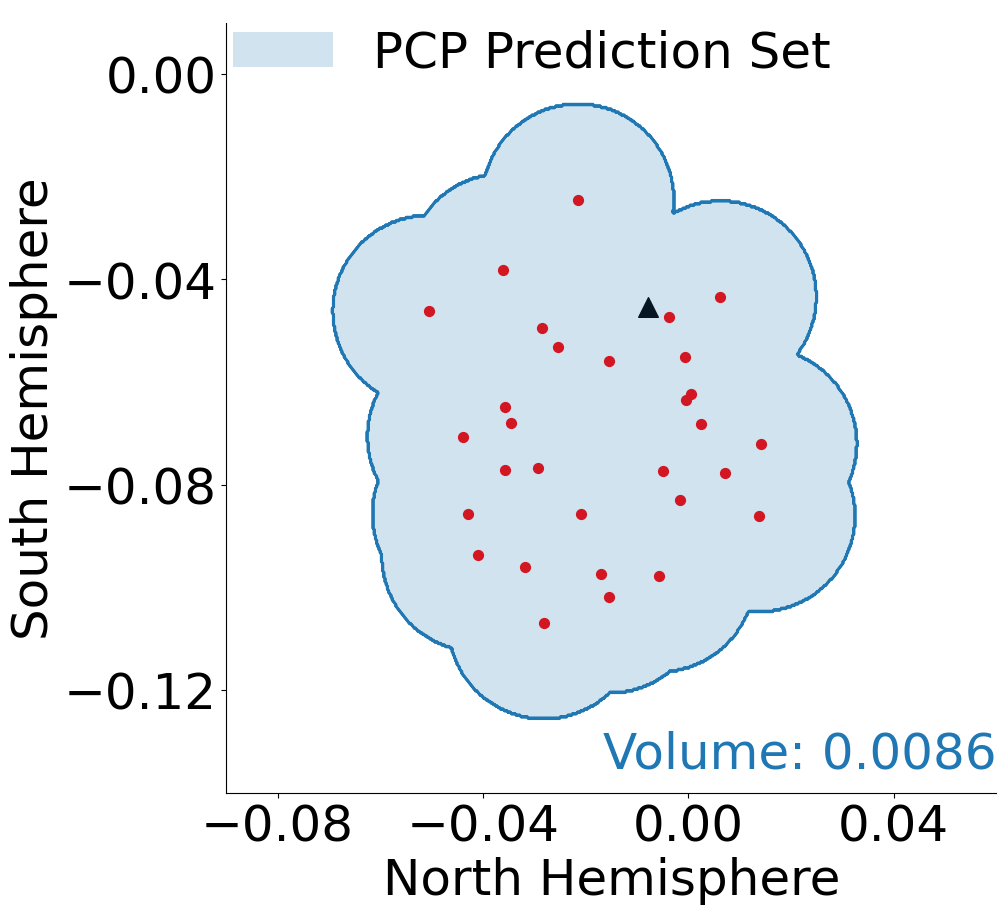

In [56]:
c_name = 'tab:blue'
dens = data_m.PCP_dens
vol = data_m.PCP_volume
cp_name = 'PCP'

fig, ax = plt.subplots(1, figsize=(10, 10))

ax.scatter(data_m.Y_ens_test[data_m.idx, :, 0], data_m.Y_ens_test[data_m.idx, :, 1], marker='o', color = 'red', s=50)
ax.scatter(data_m.Y_test[data_m.idx, 0], data_m.Y_test[data_m.idx, 1], marker='^', color = 'black', s=200)
ax.contour(data_m.CP_x, data_m.CP_y, dens, colors=c_name)
ax.contourf(data_m.CP_x, data_m.CP_y, dens, levels=[0.5, 1.5], colors=c_name, alpha=0.2)

contour_patch = Patch(facecolor=c_name, alpha=0.2, label=f'{cp_name} Prediction Set')
ax.legend(handles=[contour_patch], loc='upper left', fontsize=fontsize, frameon=False, bbox_to_anchor=(-.05, 1.05))

#ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax.set_xlabel('North Hemisphere', fontsize=fontsize)
ax.set_ylabel('South Hemisphere', fontsize=fontsize)

ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xticks([-0.08, -0.04, 0.00, 0.04])
ax.set_yticks([-0.12, -0.08, -0.04, 0.00])

ax.text(1,.02, f'Volume: {vol:.4f}', fontsize=fontsize, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color=c_name)

ax.set_xlim(-0.09, 0.06)
ax.set_ylim(-0.14, 0.01)

for spline in ['top', 'right']:
    ax.spines[spline].set_visible(False)

ax.set_aspect('equal')

fig.savefig(f'{data_m.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

# Mengze-nearest

In [33]:
data_m_n = Data('Mengze_nearest', 1, 277)

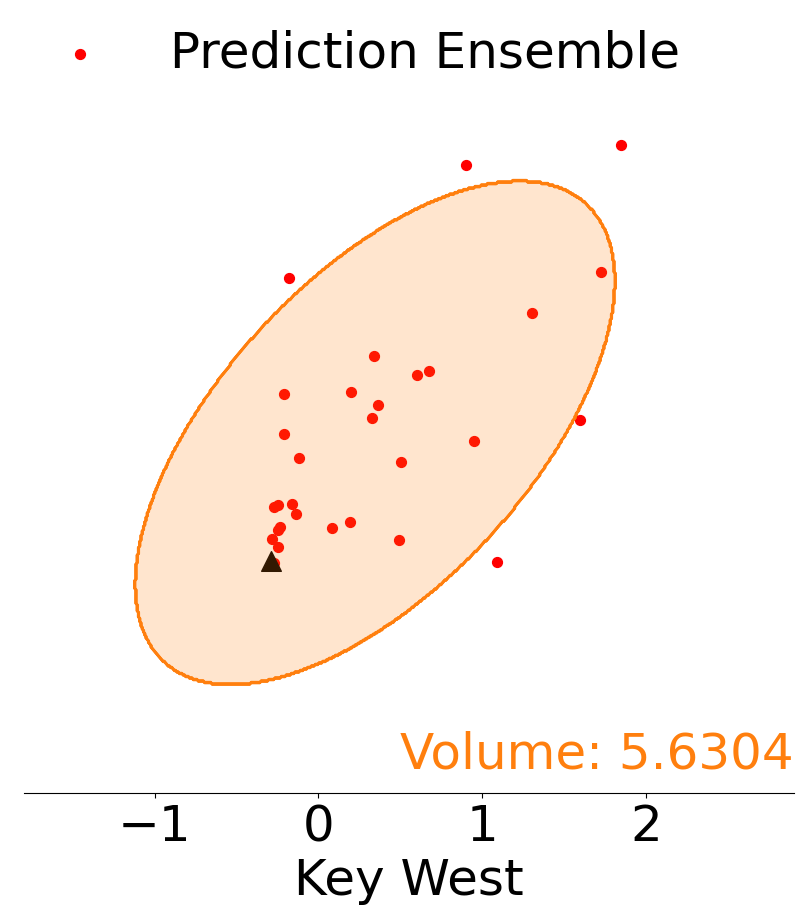

In [57]:
c_name = 'tab:orange'
dens = data_m_n.CP_dens
vol = data_m_n.CP_volume
cp_name = 'CP4Gen'

fig, ax = plt.subplots(1, figsize=(10, 10))

ax.scatter(data_m_n.Y_ens_test[data_m_n.idx, :, 0], data_m_n.Y_ens_test[data_m_n.idx, :, 1], marker='o', color = 'red', s=50, label='Prediction Ensemble')
ax.scatter(data_m_n.Y_test[data_m_n.idx, 0], data_m_n.Y_test[data_m_n.idx, 1], marker='^', color = 'black', s=200)
ax.contour(data_m_n.CP_x, data_m_n.CP_y, dens, colors=c_name)
ax.contourf(data_m_n.CP_x, data_m_n.CP_y, dens, levels=[0.5, 1.5], colors=c_name, alpha=0.2)

#contour_patch = Patch(facecolor=c_name, alpha=0.2, label=f'{cp_name} Prediction Set')
ax.legend(loc='upper left', fontsize=fontsize, frameon=False, bbox_to_anchor=(-.05, 1.05))

#ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Key West', fontsize=fontsize)
# ax.set_ylabel('Miami', fontsize=fontsize)
ax.set_ylabel('', fontsize=fontsize)

ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xticks([-1, 0, 1, 2])
# ax.set_yticks([-1, 0, 1, 2])
ax.set_yticks([])

ax.text(1,.02, f'Volume: {vol:.4f}', fontsize=fontsize, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color=c_name)

ax.set_xlim(-1.8, 2.9)
ax.set_ylim(-1.7, 3)

for spline in ['top', 'right', 'left']:
    ax.spines[spline].set_visible(False)

ax.set_aspect('equal')

fig.savefig(f'{data_m_n.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')

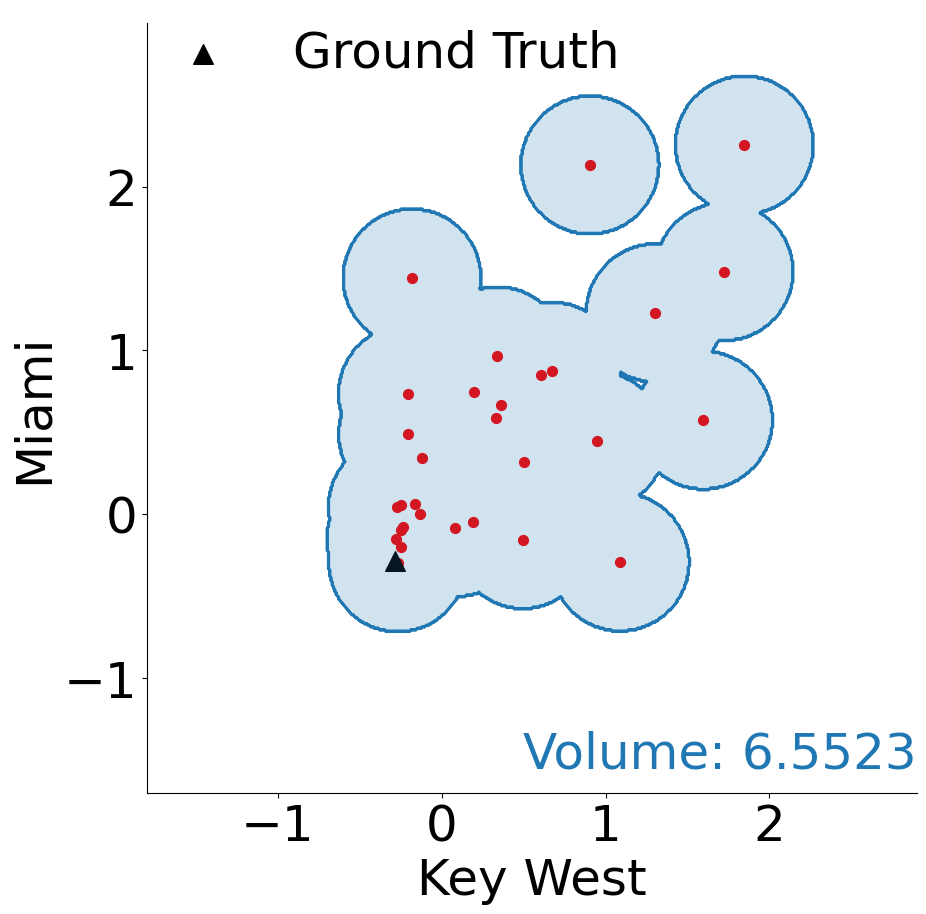

In [59]:
c_name = 'tab:blue'
dens = data_m_n.PCP_dens
vol = data_m_n.PCP_volume
cp_name = 'PCP'

fig, ax = plt.subplots(1, figsize=(10, 10))

ax.scatter(data_m_n.Y_ens_test[data_m_n.idx, :, 0], data_m_n.Y_ens_test[data_m_n.idx, :, 1], marker='o', color = 'red', s=50)
ax.scatter(data_m_n.Y_test[data_m_n.idx, 0], data_m_n.Y_test[data_m_n.idx, 1], marker='^', color = 'black', s=200, label='Ground Truth')
ax.contour(data_m_n.CP_x, data_m_n.CP_y, dens, colors=c_name)
ax.contourf(data_m_n.CP_x, data_m_n.CP_y, dens, levels=[0.5, 1.5], colors=c_name, alpha=0.2)

#contour_patch = Patch(facecolor=c_name, alpha=0.2, label=f'{cp_name} Prediction Set')
ax.legend(loc='upper left', fontsize=fontsize, frameon=False, bbox_to_anchor=(-.05, 1.05))

#ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax.set_xlabel('Key West', fontsize=fontsize)
ax.set_ylabel('Miami', fontsize=fontsize)

ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax.set_xticks([-1, 0, 1, 2])
ax.set_yticks([-1, 0, 1, 2])

ax.text(1,.02, f'Volume: {vol:.4f}', fontsize=fontsize, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color=c_name)

ax.set_xlim(-1.8, 2.9)
ax.set_ylim(-1.7, 3)

for spline in ['top', 'right']:
    ax.spines[spline].set_visible(False)

ax.set_aspect('equal')

fig.savefig(f'{data_m_n.dataset_name}_{cp_name}_case_study.pdf', bbox_inches='tight')